__Pipeline 2 - x2 Lens Galaxies__

Up to now, all of the image that we fitted had only one lens galaxy. However, we saw in chapter 1 that we can create multiple galaxies which each contribute to the strong lensing. Multi-galaxy systems are challenging to model, because you're adding an extra 5-10 parameters to the non-linear search and, more problematically, the degeneracies between the mass-profiles of the two galaxies can be severe.

However, we can nevertheless break the analysis down using a pipeline and give ourselves a shot at getting a good lens model. The approach we're going to take is we're going to fit as much about each individual lens galaxy first, before fitting them simultaneously.

Up to now, I've put a focus on pipelines being general. The pipeline we write in this example is going to be the opposite - specific to the image we're modeling. Fitting multiple lens galaxies is really difficult and writing a pipeline that we can generalize to many lenses isn't currently possible with PyAutoLens.

In [1]:
from autofit import conf
from autolens.data import ccd
from autolens.model.profiles import light_profiles as lp
from autolens.model.profiles import mass_profiles as mp
from autolens.data.plotters import ccd_plotters

Lets setup the path to the workspace, config and output folders, as per usual.

In [2]:
# If you are using Docker, the paths to the chapter is as follows (e.g. comment out this line)!
# path = '/home/user/workspace/'

# If you arn't using docker, you need to change the path below to the chapter 3 directory and uncomment it
# path = '/path/to/workspace/'

conf.instance = conf.Config(config_path=path+'config', output_path=path+'output')

This rather long simulate function generates an image with two strong lens galaxies.

In [3]:
def simulate():

    from autolens.data.array import grids
    from autolens.model.galaxy import galaxy as g
    from autolens.lens import ray_tracing

    psf = ccd.PSF.simulate_as_gaussian(shape=(11, 11), sigma=0.05, pixel_scale=0.05)

    image_plane_grid_stack = grids.GridStack.grid_stack_for_simulation(shape=(180, 180), pixel_scale=0.05, psf_shape=(11, 11))

    lens_galaxy_0 = g.Galaxy(light=lp.EllipticalSersic(centre=(0.0, -1.0), axis_ratio=0.8, phi=55.0, intensity=0.1,
                                                       effective_radius=0.8, sersic_index=2.5),
                             mass=mp.EllipticalIsothermal(centre=(1.0, 0.0), axis_ratio=0.7, phi=45.0,
                                                          einstein_radius=1.0))

    lens_galaxy_1 = g.Galaxy(light=lp.EllipticalSersic(centre=(0.0, 1.0), axis_ratio=0.8, phi=100.0, intensity=0.1,
                                                       effective_radius=0.6, sersic_index=3.0),
                             mass=mp.EllipticalIsothermal(centre=(-1.0, 0.0), axis_ratio=0.8, phi=90.0,
                                                          einstein_radius=0.8))

    source_galaxy = g.Galaxy(light=lp.SphericalExponential(centre=(0.05, 0.15), intensity=0.2, effective_radius=0.5))

    tracer = ray_tracing.TracerImageSourcePlanes(lens_galaxies=[lens_galaxy_0, lens_galaxy_1],
                                                 source_galaxies=[source_galaxy],
                                                 image_plane_grid_stack=image_plane_grid_stack)

    return ccd.CCDData.simulate(array=tracer.image_plane_image_for_simulation, pixel_scale=0.05,
                               exposure_time=300.0, psf=psf, background_sky_level=0.1, add_noise=True)

Lets simulate the image we'll fit, which is a new image, finally!

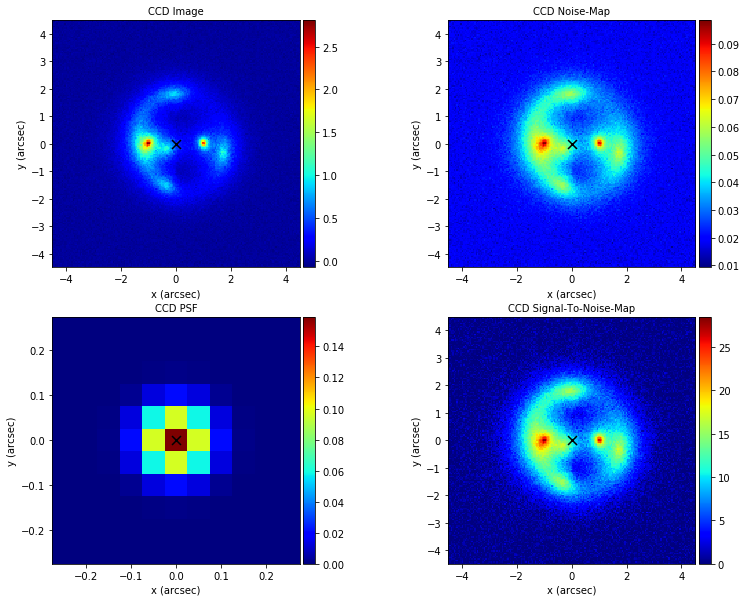

In [4]:
ccd_data = simulate()
ccd_plotters.plot_ccd_subplot(ccd_data=ccd_data)

Okay, so looking at the image, we clearly see two blobs of light, corresponding to our two lens galaxies. We also see the source's light is pretty complex - the arcs don't posses the rotational symmetry we're used to seeing up to now. Multi-galaxy ray-tracing is just a lot more complicated, which means so is modeling it!

So, how can we break the lens modeling up? We can:

1) Fit and subtract the light of each lens galaxy individually - this will require some careful masking but is doable.

2) Use these results to initialize each lens galaxy's mass-profile.

So, with this in mind, we've written a pipeline composed of 4 phases:

Phase 1) Fit the light profile of the lens galaxy on the left of the image, at coordinates (0.0", -1.0").

Phase 2) Fit the light profile of the lens galaxy on the right of the image, at coordinates (0.0", 1.0").

Phase 3) Use this lens-subtracted image to fit the source galaxy's light. The mass-profiles of the two lens galaxies can use the results of phases 1 and 2 to initialize their priors.

Phase 4) Fit all relevant parameters simultaneously, using priors from phases 1, 2 and 3.

Again, before we checkout the pipeline, lets import it, and get it running.

In [5]:
from workspace.howtolens.chapter_3_pipelines import tutorial_2_pipeline_x2_lens_galaxies

pipeline_x2_galaxies = tutorial_2_pipeline_x2_lens_galaxies.make_pipeline(
    pipeline_path='/howtolens/c3_t2_x2_lens_galaxies/')
pipeline_x2_galaxies.run(data=ccd_data)

/home/jammy/PyCharm/VirtualEnvs/AutoLensPy3/lib/python3.6/site-packages/scipy/optimize/minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


/home/jammy/PyCharm/Projects/AutoLens/workspace/output//howtolens/c3_t2_x2_lens_galaxiespipeline_x2_lens_galaxies/phase_1_left_lens_light/optimizer/multinest.txt
Removed no burn in


/home/jammy/PyCharm/VirtualEnvs/AutoLensPy3/lib/python3.6/site-packages/scipy/optimize/minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


/home/jammy/PyCharm/Projects/AutoLens/workspace/output//howtolens/c3_t2_x2_lens_galaxiespipeline_x2_lens_galaxies/phase_2_right_lens_light/optimizer/multinest.txt
Removed no burn in


AttributeError: 'LensProfileFit' object has no attribute 'unmasked_lens_plane_model_image'

Okay, great, now is a good time to read through the '_tutorial_2_pipeline_x2_lens_galaxies.py_' pipeline, to get a complete view of how it works. Once you've done that, come back here and we'll wrap up this tutorial.

And, we're done. This pipeline takes a while to run, as is the nature of multi-galaxy modeling. Nevertheless, the techniques we've learnt above can be applied to systems with even more galaxies, albeit the increases in parameters will slow down the non-linear search. Here are some more Q&A's

1) This system had two very similar lens galaxies, with comparable amounts of light and mass. How common is this? Does it make it harder to model them?

Typically, a 2 galaxy system has 1 massive galaxy (that makes up some 80%-90% of the overall light and mass), accompanied by a smaller satellite. The satellite can't be ignored - it impacts the ray-tracing in a measureable way, but this is a lot less degenerate with the 'main' lens galaxy. This means we can often model the satellite with much simpler profiles (e.g. spherical profiles). So yes, multi-galaxy systems can often be easier to model.

2) It got pretty confusing passing all those priors towards the end of the pipeline there, didn't it?

It does get confusing, I won't lie. This is why we made galaxies named objects - so that we could call them the 'left_lens' and 'right_lens'. It still requires caution when writing the pipeline, but goes to show that if you name your galaxies sensibly you should be able to avoid errors, or spot them quickly when you make them.